作为python的初学者，斗胆刷一下大刀，

希望大佬提出宝贵的意见。

RZ的core两大块：
    目标公司的五行分析
    数据的阴阳分析
第一篇，主要说明从招股书如何分析一家公司
        如何分析换手率（数据分析的核心，没有之一）

换手率是无法准确得到的，我们只能做修正，或者说尽力接近。

In [1]:
# 首先是拿数据，我们用到了akshare，efinance两个模块
# 获得日线数据
import akshare as ak
# 获得公司财务数据
import efinance as ef
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rcParams['font.sans-serif']=['Microsoft Yahei']
mpl.rcParams['axes.unicode_minus']=False


In [2]:
# 财务数据是以季度为单位做报表的，所以我们需要一个季度为纲的数列
holders=pd.DataFrame()
rng = pd.period_range('2015Q1',datetime.datetime.now()+pd.tseries.offsets.DateOffset(days=200),freq='Q-DEC')
df= pd.Series(np.arange(len(rng)),index=rng)
df.index.name='更新日期'
holders['序列'] =df
holders.tail(3)

,序列
更新日期,
2023Q1,32
2023Q2,33
2023Q3,34


In [3]:
# 获得目标股票的十大流通股东信息，并清洗
for code,name in[['sz000519','茅台']]:
    print(code)
    stock_code = code[2:]
    # 获取个股十大流通股东信息, top = 4 表示最近的 4 次公开信息
    try:
        df = ef.stock.get_top10_stock_holder_info(stock_code,top =4)
        # 对持股比例 num化
        df['持股比例']=df.apply(lambda x:float(x.持股比例[:-1]),axis=1)
        #获得持股比利大于5%的股东信息 好想嫁给王四清
        df =df[df['持股比例']>=5]
        # print(df)
        # 按照日期对持股比利分类汇总
        D=df.groupby(['更新日期'], as_index=False,axis=0)['持股比例'].sum()
        D.columns=['更新日期',code]
        D['更新日期'] = pd.to_datetime(D['更新日期'])
        D=D.set_index('更新日期')
        holder_df=D
        holder_df=holder_df.to_period("Q")
        print(holder_df.tail(3))
        # print(holder_df)
        # holders=pd.merge_asof(holders, holder_df, on='更新日期')
        # print(holders,'z这个是holders')
    except:
        holders[code]=0


sz000519
        sz000519
更新日期            
2022Q1     28.61
2022Q2     28.61
2022Q3     28.61


In [4]:
# 获得股票基础数
df = ak.stock_zh_a_hist(symbol=code[2:8], period="daily", start_date='20211001',adjust="qfq")
# 成交量修正
df["成交量"]=df["成交量"]*100
df.tail(3)
# df

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
296,2022-12-22,19.47,19.04,19.58,18.96,21998400,4.238886e+08,3.20,-1.70,-0.33,1.58
297,2022-12-23,18.90,19.15,19.19,18.81,14576800,2.773597e+08,2.00,0.58,0.11,1.05
298,2022-12-26,19.38,19.95,19.99,19.28,31643100,6.239427e+08,3.71,4.18,0.80,2.27


In [5]:
# 数据拼接
# 将数据格式统一
df['日期']=pd.to_datetime(df['日期'])
df.set_index('日期', inplace=True,drop=False)
df=df.to_period("Q")
df.index.name='更新日期'
# print(df)
# 拼接
stock_df=pd.merge_asof(df, holder_df, on='更新日期')
stock_df.rename(columns={code:'流通率'}, inplace = True)
# 计算流通换手率
stock_df['流通换手率']=stock_df['换手率']*(100/(100-stock_df['流通率']))
# stock_df['流通换手率']=stock_df.apply(lambda x:x.换手率*(100/(100-x.流通率)),axis=1)
stock_df.set_index('日期')
stock_df['流通换手率']=stock_df['流通换手率'].round(3)
stock_df.tail(3)


,更新日期,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,流通率,流通换手率
296,2022Q4,2022-12-22,19.47,19.04,19.58,18.96,21998400,4.238886e+08,3.20,-1.70,-0.33,1.58,28.61,2.213
297,2022Q4,2022-12-23,18.90,19.15,19.19,18.81,14576800,2.773597e+08,2.00,0.58,0.11,1.05,28.61,1.471
298,2022Q4,2022-12-26,19.38,19.95,19.99,19.28,31643100,6.239427e+08,3.71,4.18,0.80,2.27,28.61,3.180


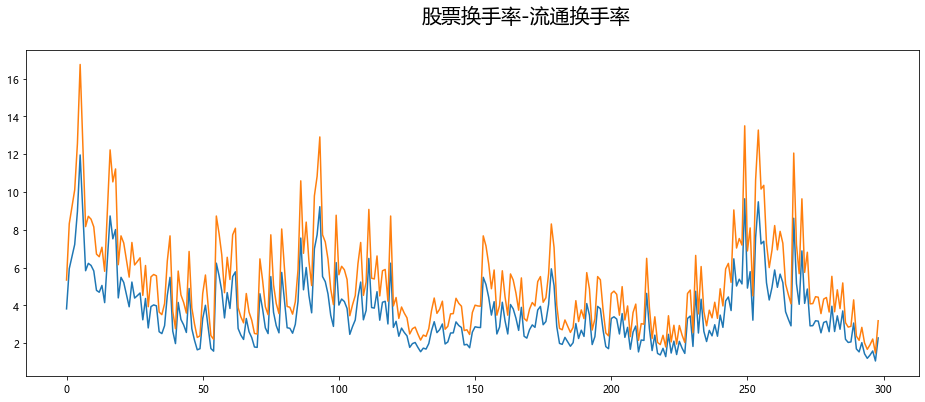

In [9]:
# 不画图感觉少点什么
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle("股票换手率-流通换手率", x=0.65, fontsize=20, ha="right") #为figure添加标题
ax.plot(stock_df['换手率'],label="stock close price") #绘制图像
ax.plot(stock_df['流通换手率'],label="stock close price") #绘制图像

